# Estimating network latency and capacity from asymmetric measures

We first load our dependencies and download the provided datasets if required.

In [1]:
%matplotlib inline
from os import path
from urllib.request import urlretrieve
import gzip

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
lan_url = 'http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/liglab2.log.gz'
lan_file = 'liglab2.log.gz'

if not path.exists(lan_file):
    urlretrieve(lan_url, lan_file)
    
wan_url = 'http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/stackoverflow.log.gz'
wan_file = 'stackoverflow.log.gz'

if not path.exists(wan_file):
    urlretrieve(wan_url, wan_file)

## First dataset: Local Area Network conditions

### Data extraction

The first dataset contains ping results. Here is an extract of the provided data.

In [3]:
with gzip.open(lan_file, 'rb') as f:
    for _ in range(5):
        print(next(f))

b'[1421761682.052172] 665 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=22.5 ms\n'
b'[1421761682.277315] 1373 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=21.2 ms\n'
b'[1421761682.502054] 262 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=21.2 ms\n'
b'[1421761682.729257] 1107 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=23.3 ms\n'
b'[1421761682.934648] 1128 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=1.41 ms\n'


We create a function to parse these log lines and test it.

In [4]:
def parse_ping_line(l):
    assert len(l) > 0
    assert l[0] == '['
    
    timestamp = pd.Timestamp(float(l[1:l.index(']')]), unit='s')
    size = np.nan
    rtt = np.nan
    
    tokens = l.split(' ')
    for i, t in enumerate(tokens):
        if t == 'bytes':
            assert np.isnan(size)
            size = int(tokens[i-1])
        elif t.startswith('time='):
            rtt = float(t[len('time='):])
    
    return [timestamp, size, rtt]
    
test_line = '[1421761682.052172] 665 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=22.5 ms\n'
[timestamp, size, rtt] = parse_ping_line(test_line)
assert timestamp == pd.Timestamp('2015-01-20 13:48:02.052172')
assert size == 665
assert rtt == 22.5

We can now process our full dataset and check if any data is missing.

In [5]:
rows = []
with gzip.open(lan_file, 'rb') as f:
    for l in f:
        try:
            rows.append(parse_ping_line(l.decode()))
        except (AssertionError):
            print('invalid line', l)

df = pd.DataFrame(rows, columns=['timestamp', 'size', 'rtt']).set_index('timestamp').sort_index()
print(df[df.isnull().any(axis=1)].head())

                               size  rtt
timestamp                               
2015-01-20 13:48:04.770828000    21  NaN
2015-01-20 13:48:26.146320000     9  NaN
2015-01-20 13:49:08.647974000     9  NaN
2015-01-20 13:49:48.500515999     9  NaN
2015-01-20 13:50:05.331125000    18  NaN


The value `rtt` is missing from some rows. We remove these measurements.

In [6]:
df = df.dropna().copy()
df.describe()

size           rtt
count  44036.000000  44036.000000
mean    1000.025729      5.136663
std      573.659666     12.221312
min       24.000000      1.000000
25%      499.000000      1.270000
50%      989.000000      1.440000
75%     1499.000000      2.310000
max     2007.000000    276.000000

### Data analysis

We plot the rtt along time axis, with different levels of zooms.

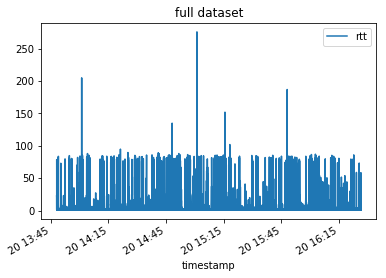

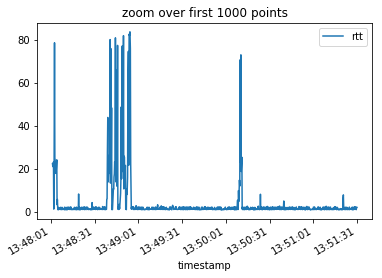

In [7]:
df.plot(y='rtt', title='full dataset')
df[:1000].plot(y='rtt', title='zoom over first 1000 points')

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


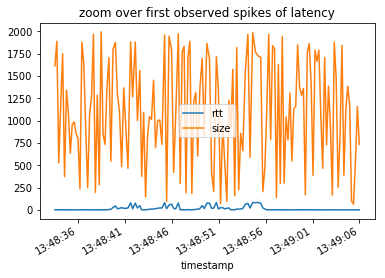

In [8]:
df[150:300].plot(y=['rtt', 'size'], title='zoom over first observed spikes of latency')

We can observe spikes of latency (rtt) in the dataset.The last plot suggests that the packet size **is not** the only parameter that affects latency.

We now study the relation between packet size and rtt.

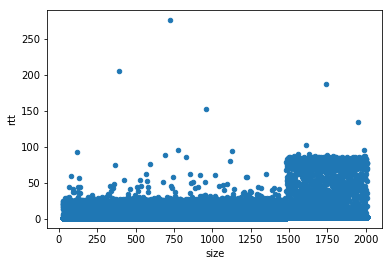

In [9]:
df.plot(x='size', y='rtt', kind='scatter')

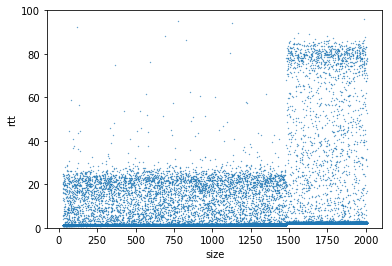

In [10]:
# Do not display outsiders on plot, reduce point size
df.plot(x='size', y='rtt', kind='scatter', ylim=(0, 100), s=.1)

We "zoom" over the discontinuity ($S \approx 1480$).

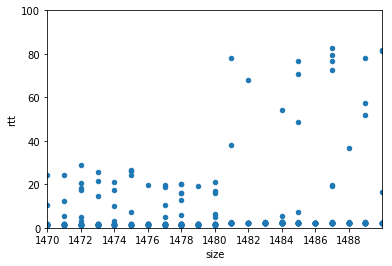

In [11]:
df.plot(x='size', y='rtt', kind='scatter', xlim=(1470,1490), ylim=(0,100), xticks=range(1470,1490, 2))

In [12]:
split = 1481
df1 = df[df['size'] < split]
df2 = df[df['size'] >= split]

We can now compute the linear regression over the two domains to find $L$ and $C$ with the following model:

$T(S) = L + \frac{S}{C}$

(in this notebook, $T = \text{rtt}$ and $S = \text{size}$)

L = 3.2756741993939427, C = 3064.5146168986485
L = 5.289832573707122, C = 387.76039978488734


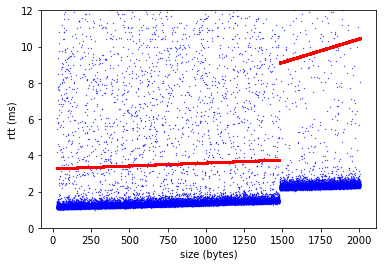

In [13]:
def linear_regression(df):
    X = df['size']
    X = sm.add_constant(X)
    model = sm.OLS(df['rtt'], X).fit()

    L = model.params['const']
    C = 1 / model.params['size']
    print('L = {}, C = {}'.format(L, C))
    
    S = df['size']
    plt.scatter(S, df['rtt'], label='data', s=.1, c='b')
    plt.scatter(S, L+S/C, label='regression', s=1, c='r')

plt.ylim(0, 12)
plt.xlabel('size (bytes)')
plt.ylabel('rtt (ms)')
    
linear_regression(df1)
linear_regression(df2)

It seems that our model is deeply impacted by random noise.

We now change our regression model to **Quantile regression**, using lowest 10%.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


L = 1.06406439909992, C = 4246.666107740117
L = 1.76962443179832, C = 4049.957445584297


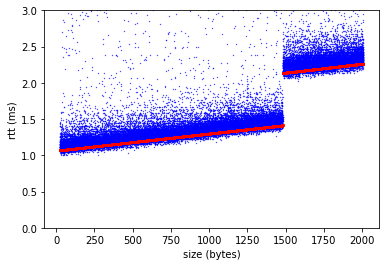

In [14]:
def quantile_linear_regression(df):
    X = df['size']
    X = sm.add_constant(X)
    model = sm.QuantReg(df['rtt'], X).fit(q=0.1)

    L = model.params['const']
    C = 1 / model.params['size']
    print('L = {}, C = {}'.format(L, C))
    
    S = df['size']
    plt.scatter(S, df['rtt'], label='data', s=.1, c='b')
    plt.scatter(S, L+S/C, label='regression', s=1, c='r')

plt.ylim(0, 3)
plt.xlabel('size (bytes)')
plt.ylabel('rtt (ms)')
    
quantile_linear_regression(df1)
quantile_linear_regression(df2)

This model has a better fit on the smallest values of rtt for each packet size.

## Second dataset: Wide Area Network conditions (StackOverflow)

We apply the same analysis for our second dataset.

In [15]:
rows = []
with gzip.open(wan_file, 'rb') as f:
    for l in f:
        try:
            rows.append(parse_ping_line(l.decode()))
        except (AssertionError):
            print('invalid line', l)

df = pd.DataFrame(rows, columns=['timestamp', 'size', 'rtt']).set_index('timestamp').sort_index()
print(df[df.isnull().any(axis=1)].head())
df = df.dropna().copy()
df.describe()

                            size  rtt
timestamp                            
2015-01-20 16:27:00.808824    12  NaN
2015-01-20 16:27:26.232560    22  NaN
2015-01-20 16:28:27.915612    11  NaN
2015-01-20 16:28:43.190747    22  NaN
2015-01-20 16:28:54.255838    16  NaN


size          rtt
count  6824.000000  6824.000000
mean   1005.615475   114.230657
std     576.383830     8.056183
min      24.000000   110.000000
25%     498.000000   111.000000
50%    1001.500000   111.000000
75%    1510.000000   112.000000
max    2007.000000   163.000000

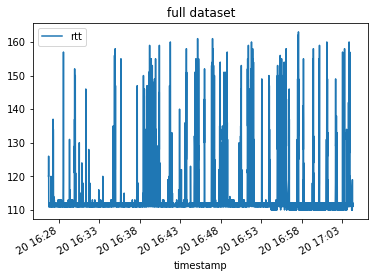

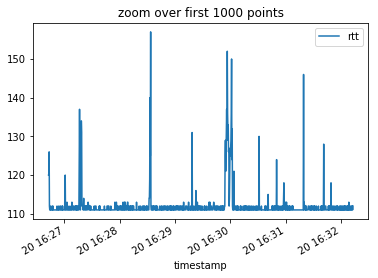

In [16]:
df.plot(y='rtt', title='full dataset')
df[:1000].plot(y='rtt', title='zoom over first 1000 points')

Like previous dataset, we observe some spikes. The base latency seems to be much larger.

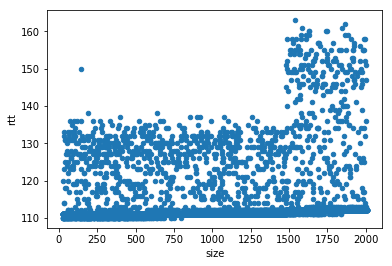

In [17]:
df.plot(x='size', y='rtt', kind='scatter')

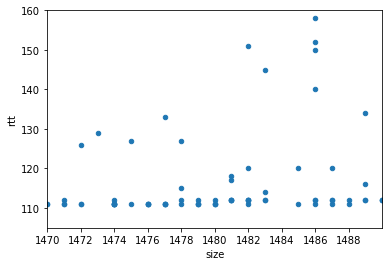

In [18]:
df.plot(x='size', y='rtt', kind='scatter', xlim=(1470,1490), ylim=(105,160), xticks=range(1470,1490, 2))

Again, we have a discontinuity around $S \approx 1480$ but it is more difficult to assert it precisely.

In [19]:
split = 1481
df1 = df[df['size'] < split]
df2 = df[df['size'] >= split]

L = 113.22750968484881, C = 22119.029139904094
L = 120.05358833473096, C = -554.6631211596213


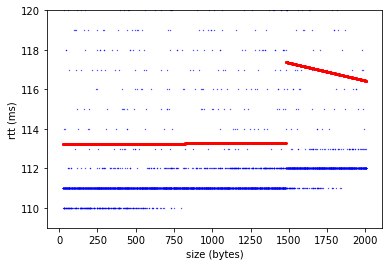

In [20]:
plt.ylim(109, 120)
plt.xlabel('size (bytes)')
plt.ylabel('rtt (ms)')
linear_regression(df1)
linear_regression(df2)

The previous regression model also seems very disturbed by the high level of noise introduced by the experiment (especially for the second domain). 
It is worth noting that rtt precision is reduced to millisecond (compared to first lan dataset).

We re-apply quantile regression.

L = 110.99999716220327, C = 450852383.71053827
L = 111.99999672413105, C = 585118939.8129449


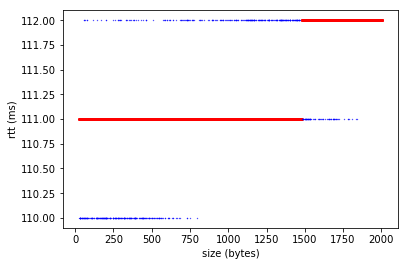

In [21]:
plt.ylim(109.9, 112.1)
plt.xlabel('size (bytes)')
plt.ylabel('rtt (ms)')
quantile_linear_regression(df1)
quantile_linear_regression(df2)

$C$ is very high: this means that this model is **constant** over the two domains.
    
* $L = 111$ ms if $S < 1481$
* $L = 112$ ms if $S \geq 1481$

## A word on the discontinuity

The `ping` command sends `ICMP` packets [1] with an IPv4 header of 20 bytes [2].

These packets are split when their size exceed the link MTU, commonly set to 1500 bytes [3]. This explains why we have a discontinuity at size 1480 bytes: `ping` introduces around 1 ms of additional latency for the second packet it needs to send.

[1]: https://linux.die.net/man/8/ping
[2]: https://en.wikipedia.org/wiki/Ping_(networking_utility)#Message_format
[3]: https://en.wikipedia.org/wiki/Maximum_transmission_unit#MTUs_for_common_media